In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np

homedir = os.getcwd()

In [2]:
# Load BEID's and company metadata
print('Loading company information...')
metadata = pd.read_excel(os.path.join(homedir,'metadata.xlsx'))

# load commodity code / commodity name into dataframe commodities
print('Loading all commodities...')
commodities = pd.read_csv(os.path.join(homedir,'goederengroepen.txt'),sep=',', header=0, encoding='latin8')

# load regkol code / regkol name into dataframe regkols
print('Loading all nace codes...')
regkols = pd.read_csv(os.path.join(homedir,'regkols.txt'),sep=',', header=0, encoding='latin8')

# load RELEVANT regkol code / regkol name into dataframe regkols_rel
print('Loading relevant codes...')
regkols_rel = pd.read_csv(os.path.join(homedir,'regkols_relevant.txt'),sep=',', header=0, encoding='latin8')

Loading company information...
Loading all commodities...
Loading all nace codes...
Loading relevant codes...


In [3]:
# if commodity name: return commodity code
# if commodity code: return commodity name
def get_commodity(name_or_code):
    if isinstance(name_or_code,int): 
        return commodities.loc[commodities['gg_code'] == name_or_code]['gg_info'].values[0]
    return commodities.loc[commodities['gg_info'] == name_or_code]['gg_code'].values[0]

# if regkol name: return regkol code
# if regkol code: return regkol name
def get_regkol(name_or_code):
    if isinstance(name_or_code,int): 
        return regkols.loc[regkols['rk_code'] == name_or_code]['rk_info'].values[0]
    return regkols.loc[regkols['rk_info'] == name_or_code]['rk_code'].values[0]

In [4]:
# if supply = 'supply': return producers of commodity commodity
# if supply = 'use':    return consucers of commodity commodity
def get_companies(supply,commodity):
    commodity = str(commodity) + '.csv'
    path = os.path.join(homedir,supply,commodity)
    companies = pd.read_csv(path,sep=';').rename(columns={'id':'BEID','nace':'nace_code'})
    irrelevant_columns = ['lon','lat','score','indegree','outdegree']
    for column in irrelevant_columns:
        if column not in companies.columns:
            irrelevant_columns.remove(column)
    companies = companies.drop(irrelevant_columns,axis=1)
    if companies['volume'].dtype == object:
        companies['volume'] = companies['volume'].str.split(',').str[0]
    companies['volume'] = companies['volume'].astype('int64')
    companies['rel_volume'] = companies['volume']/companies['volume'].sum()*100
    companies['commodity_code'] = commodity.split('.')[0]
    companies['supply/use'] = supply
    return companies.sort_values(['volume'],ascending=False)

def add_metadata(df):
    return pd.merge(df,metadata,how='left',on='BEID')

In [5]:
def value_chain(commodities):
    value_chain = pd.DataFrame()
    for commodity in commodities:
        if isinstance(commodity,str):
            commodity = get_commodity(commodity)
        for role in ['supply','use']:
            value_chain = pd.concat([value_chain,get_companies(role,commodity)])
    value_chain['commodity_code'] = value_chain['commodity_code'].astype(int)
    value_chain['supply/use'] = value_chain['supply/use'].astype(str)
    return value_chain

def calculate_statistics(value_chain):
    # split by commodity, supply/use and industry
    niches = value_chain.groupby(['commodity_code','supply/use','nace_code'],sort=False)
    # for all fragments: count number of companies, sum of relative volume and absolute volume
    all_stats = niches['BEID'].count().reset_index()
    all_stats['rel_volume'] = niches['rel_volume'].sum().reset_index()['rel_volume']
    all_stats['abs_volume'] = niches['volume'].sum().reset_index()['volume']
    # add commodity totals
    commodity_totals = value_chain.groupby(['commodity_code','supply/use'])['volume'].sum().reset_index()
    all_stats['commodity_title'] = all_stats['commodity_code'].apply(lambda x: get_commodity(int(x)))
    all_stats['nace_title'] = all_stats['nace_code'].apply(lambda x: get_regkol(int(x)))
    all_stats = pd.merge(all_stats, commodity_totals, how='left')
    all_stats = all_stats.reindex(columns = ['commodity_title','supply/use','nace_title','rel_volume','abs_volume','BEID','volume'])
    return all_stats.groupby(['commodity_title','supply/use','nace_title']).first()

def filter_naces(relevant_nodes):
    relevant_naces = regkols_rel['rk_code'].tolist()
    return relevant_nodes[relevant_nodes['nace_code'].isin(relevant_naces)]


def original_commodity_volumes(all_nodes):
    return all_nodes.groupby(['commodity_code','supply/use'])['volume'].sum() 

def select_q_victims(candidates,quantity):
    direct_victims = pd.DataFrame(columns=candidates.columns)
    for i in range(0,quantity):
        target_node = candidates.sample()
        candidates = candidates.drop(target_node.index)
        direct_victims = pd.concat([direct_victims,target_node])
    return direct_victims

def simulate_victims(commodity_seq,deletions):
    all_nodes = value_chain(commodity_seq)
    original_volumes = original_commodity_volumes(all_nodes)
    nodes_filtered = filter_naces(all_nodes)
    commodity_code = get_commodity(commodity_seq[0])
    candidates = all_nodes[(all_nodes['commodity_code'] == commodity_code) & (all_nodes['supply/use'] == 'supply')]
    direct_victims = select_q_victims(candidates,deletions)    
    return direct_victims


def descriptive_statistics(commodity_seq):
    all_nodes = value_chain(commodity_seq)
    filtered_nodes = filter_naces(all_nodes)
    commodity_totals = filtered_nodes.groupby(['commodity_code','supply/use'])['volume'].sum().reset_index()

    sur = []
    for commodity_text in commodity_seq:
        commodity = get_commodity(commodity_text)
        print(commodity)
        supply_use = commodity_totals.loc[commodity_totals['commodity_code'] == commodity]['volume'].tolist()
        print(supply_use)
        sur.append(supply_use[1]/supply_use[0]*100)
    print(sur)
    

In [46]:
def get_volumes(nodes):
    return nodes.groupby(['commodity_code','supply/use'])['volume'].sum().reset_index()

def check_deficit(stats, commodity_seq):
    for commodity in commodity_seq:
        layer = stats[stats['commodity_code']==get_commodity(commodity)]
        if (layer['actual_deficit']>0).any():
            return commodity, layer['actual_deficit'][0]
    return None, 0

def find_shortage_victim(nodes, commodity, volume):
    candidates = nodes[nodes['commodity_code'] == get_commodity(commodity)]
    producing_candidates = candidates[candidates['supply/use'] == 'use']
    large_producing_candidates = producing_candidates[producing_candidates['volume'] > volume]
    return large_producing_candidates.loc[large_producing_candidates['volume'].idxmin()]

def highest_producer(nodes):
    return nodes.loc[nodes['volume'].idxmax()]

def get_fraction(initial_volumes,commodity):
    volumes = initial_volumes[initial_volumes['commodity_code'] == get_commodity(commodity)]['volume']
    production = volumes[0]
    consumption = volumes[1]
    fraction = consumption/production
    if fraction > 1: 
        return 1
    return fraction

def run_experiment(commodity_seq, n_removed_nodes):
    # get nodes, filter, calculate initial volumes
    all_nodes = value_chain(commodity_seq)
    filtered_nodes = filter_naces(all_nodes)
    initial_volumes = get_volumes(filtered_nodes)
    history = pd.DataFrame()
    history = history.append(get_statistics(filtered_nodes,initial_volumes,0))
    targeted_nodes = pd.DataFrame()
    victimized_nodes = pd.DataFrame()    
    for i in range(1, n_removed_nodes+1):

        # get producers of initial resource
        companies_r = filtered_nodes[filtered_nodes['commodity_code'] == get_commodity(commodity_seq[0])]
        producers_r = companies_r[companies_r['supply/use'] == 'supply']

        # get target node
        targeted_node = producers_r.loc[producers_r['volume'].idxmax()]
        filtered_nodes = filtered_nodes[filtered_nodes.BEID != targeted_node.BEID]
        targeted_nodes = pd.concat([targeted_nodes,targeted_node])

        # calculate current volumes
        stats = get_statistics(filtered_nodes, initial_volumes, i)
        
        stats['relative_deficit']  = stats['actual_deficit']/stats['initial_volume'] 
        
        # check for deficits
        problem_commodity, volume_deficit = check_deficit(stats, commodity_seq)
        

        while volume_deficit > 0:
            
            large_consumers = filtered_nodes[filtered_nodes['commodity_code']== get_commodity(problem_commodity)]
            large_consumers = large_consumers[large_consumers['supply/use'] == 'use']

            # consumers that can fix the deficit by themselves 
            large_enough_consumers = large_consumers[large_consumers['volume'] > volume_deficit]

            if large_enough_consumers.empty:
                victim_node = large_consumers.loc[large_consumers['volume'].idxmax()]
            else:
                victim_node = large_enough_consumers.loc[large_enough_consumers['volume'].idxmin()]
            victimized_nodes = pd.concat([victimized_nodes,victim_node])
            filtered_nodes = filtered_nodes[filtered_nodes.BEID != victim_node.BEID]
            stats = get_statistics(filtered_nodes, initial_volumes, i)
            problem_commodity, volume_deficit = check_deficit(stats, commodity_seq)
            
        history = history.append(stats)
    return history

def get_statistics(nodes, initial_volumes, i):
    # calculate current volumes
    current_volumes = get_volumes(nodes)
    delta_volumes = (initial_volumes['volume'] - current_volumes['volume'])
    stats = initial_volumes.rename(columns={'volume':'initial_volume'})
    stats['current_volume'] = current_volumes['volume']
    stats['delta_volume'] = delta_volumes

        # calculate upscaling capacity of producers
    stats['max_upscaling'] = np.where(stats['supply/use'] == 'supply', stats['current_volume']*0.2, 0)
    stats['deficit_no_upscaling'] = np.where(stats['supply/use'] == 'use', pd.rolling_apply(stats['delta_volume'], 2, lambda x: x[0] - x[1]),0)

    stats.loc[:,'deficit_no_upscaling'] = stats.deficit_no_upscaling.shift(-1).fillna(0)
    stats['actual_deficit'] = stats['deficit_no_upscaling'] - stats['max_upscaling']
    stats['nodes_removed'] = i
    return stats

In [47]:
def split_results(outcome,commodity):
    fragment = outcome[outcome['commodity_code'] == get_commodity(commodity)]
    producers = fragment[fragment['actual_deficit'] != 0.0]
    consumers = fragment[fragment['actual_deficit'] == 0.0]
    return producers, consumers

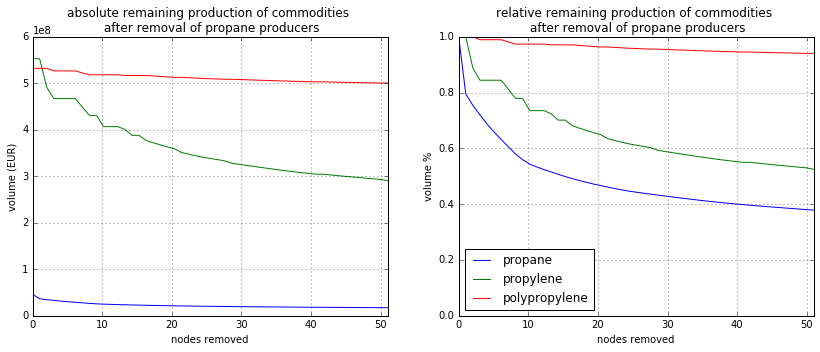

In [178]:
%matplotlib inline

outcome = run_experiment(['Vloeib.PropaanButaan','Propyleen','Polypropyleen'], 50)

outcome

propaan_prod, propaan_cons = split_results(outcome,'Vloeib.PropaanButaan')
propyleen_prod, propyleen_cons = split_results(outcome,'Propyleen')
polypropyleen_prod, polypropyleen_cons = split_results(outcome,'Polypropyleen')

propaan_volumes = propaan_prod['current_volume']
propyleen_volumes = propyleen_prod['current_volume']
polypropyleen_volumes = polypropyleen_prod['current_volume']

graph_abs = pd.DataFrame()
graph_abs['propane']= pd.Series(propaan_volumes.values)
graph_abs['propylene'] = pd.Series(propyleen_volumes.values)
graph_abs['polypropylene'] = pd.Series(polypropyleen_volumes.values)

graph_rel = pd.DataFrame()
graph_rel['propane'] = graph_abs['propane']/graph_abs['propane'].max()
graph_rel['propylene'] = graph_abs['propylene']/graph_abs['propylene'].max()
graph_rel['polypropylene'] = graph_abs['polypropylene']/graph_abs['polypropylene'].max()

graph_abs['nodes removed'] = np.linspace(0,len(propaan_volumes),len(propaan_volumes))
graph_rel['nodes removed'] = np.linspace(0,len(propaan_volumes),len(propaan_volumes))

fig, axes = plt.subplots(nrows=1, ncols=2, sharex= True)

graph_abs.plot(x='nodes removed',y=['propane','propylene','polypropylene'],kind='line', 
                title='absolute remaining production of commodities \n after removal of propane producers',
               figsize=(14,5), grid=True, ax=axes[0], ylim =0, legend=False)

graph_rel.plot(x='nodes removed',y=['propane','propylene','polypropylene'],kind='line', 
                title='relative remaining production of commodities \n after removal of propane producers',
               figsize=(14,5), grid=True, ax=axes[1], ylim=0)

axes[0].set_ylabel('volume (EUR)')
axes[1].set_ylabel('volume %')

plt.savefig('ai')
plt.show()

In [179]:
def get_plot(commodity,producers,consumers,primary_conversion,colors):
    graph = pd.DataFrame()
    col_names = [commodity+' supply',commodity+' demand']
    if primary_conversion:
        extra_columns=['negated_demand','production_capacity']
        for item in extra_columns:
            col_names.append(item)
    graph[col_names[0]] = pd.Series(producers['current_volume'].values)
    graph[col_names[1]] = pd.Series(consumers['current_volume'].values)
    if primary_conversion:
        graph[col_names[2]] = pd.Series(consumers['delta_volume'].values)
        graph[col_names[3]] = pd.Series(producers['current_volume'].values+producers['max_upscaling'].values)
    ax = graph.plot(figsize = (7,5),x=np.linspace(0,len(producers),len(producers)),y=col_names,color=colors,ylim=0, title='absolute production', grid=True)
    ax.set_ylabel('volume (EUR)')
    ax.set_xlabel('nodes removed')
    return ax

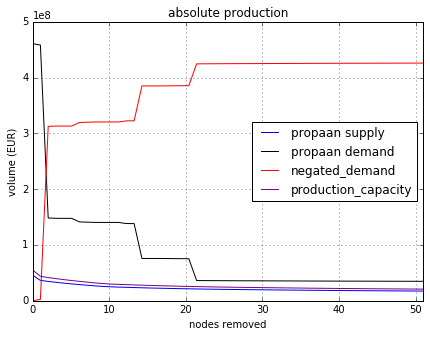

In [180]:
get_plot('propaan',propaan_prod,propaan_cons,True,['blue','black','red','purple'])
plt.savefig('propane')
plt.show()

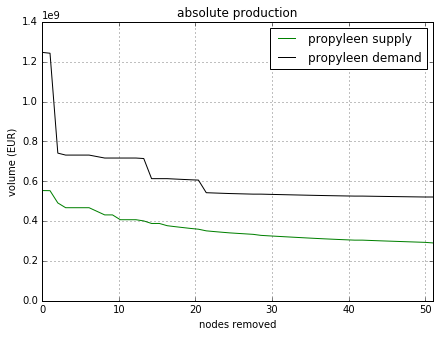

In [181]:
get_plot('propyleen',propyleen_prod,propyleen_cons,False,['green','black'])
plt.savefig('propylene')
plt.show()

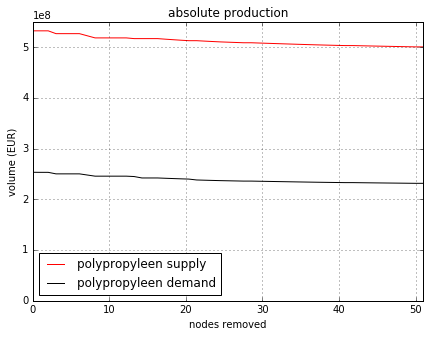

In [182]:
get_plot('polypropyleen',polypropyleen_prod,polypropyleen_cons,False,['red','black'])
plt.savefig('polypropylene')
plt.show()